In [5]:
include("../code/plotting_utilities.jl")
include("../code/ode_helper.jl")
include("../code/learn_polynomial_with_side_info.jl")
include("../code/vectorfield_helper.jl")

using Dates
using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots
using Random
using PyPlot
using JSON
using ProgressBars
PyPlot.rc("font", family="sans-serif", size=20)
PyPlot.rc("figure", autolayout=true)

Loaded diff equations


In [6]:
function get_vf_for_parameters(params)
    rho, sigma, beta = params
    f(x, y, z) =    [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]
    return f
end

get_vf_for_parameters (generic function with 1 method)

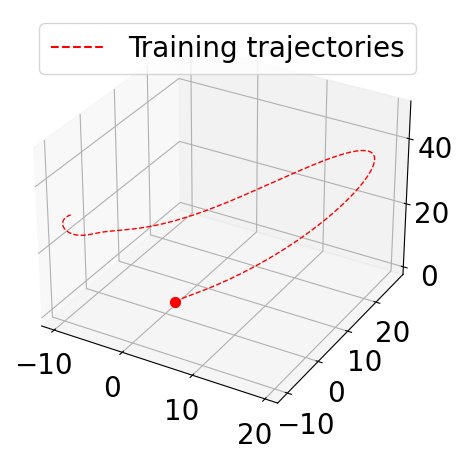

In [7]:
gr(size=(600,400))

ode_p = [28., 10., 8. / 3.]
ff = get_vf_for_parameters(ode_p)
Tf = 1.0 # T final
x0 =  [1.0, 1.0, 1.0]
box = ((-10, 10, .5), (-10, 10, .5), (-10, 10, .5))
sol = solve_ode(ff, x0, tspan=(0., Tf), length=4000, verbose=false)
PyPlot.plot3D(sol..., color=:red, ls="--", lw=1)
PyPlot.scatter3D(x0[1], x0[2], x0[3], color=:red, s=50)
PyPlot.plot([], [], [], color=:red, ls="--", label="Training trajectories")
PyPlot.legend();

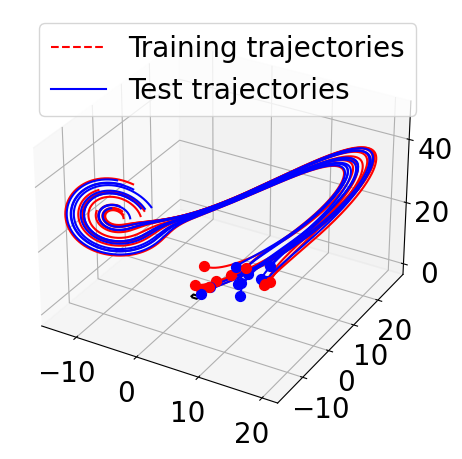

PyObject <matplotlib.legend.Legend object at 0x7fa10fa3c4c0>

In [13]:
Random.seed!(0)
training_initial_conditions = [ 10 .* rand(3) for _ in 1:10 ]
test_initial_conditions = [10 .* rand(3) for _ in 1:10]
#initial_conditions = [rand(2) for _ in 1:10]
for x0 in training_initial_conditions[1:end]
    sol = solve_ode(ff, x0, length=1000, tspan = (0., Tf), verbose=false)
    PyPlot.plot3D(sol..., color=:red)
    PyPlot.scatter3D(x0..., color=:red, s=50)
end

for x0 in test_initial_conditions[1:end]
    sol = solve_ode(ff, x0, length=1000, tspan = (0., Tf), verbose=false)
    PyPlot.plot3D(sol..., color=:blue)
    PyPlot.scatter3D(x0..., color=:blue, s=50)
end

PyPlot.plot3D([], [], [], color=:red, ls="--", label="Training trajectories")
PyPlot.plot3D([], [], [], color=:blue, label="Test trajectories")
plot_box()
PyPlot.legend()


In [14]:
pos_x(model, p, x) = begin
    S = @set x[2] - x[1] >=  0
    SS = @set x[2] - x[1] <=  0
    @constraint(model, p[1] >= 0, domain=S) 
    @constraint(model, p[1] <= 0, domain=SS) 
end

monotonicity(model, p, x) = begin
    p1, p2, p3 = p
    x1, x2, x3 = x
    @constraint model differentiate(p1, x1) <= 0
    @constraint model differentiate(p2, x2) <= 0
    @constraint model differentiate(p3, x3) <= 0
end


equilibrium_points(model, p, x) = begin
    for pi in p
        @constraint model pi(0, 0, 0) == 0
    end
end

equilibrium_points (generic function with 1 method)

In [15]:
side_info = Dict("equilibrium_points" => equilibrium_points,
        "pos_X" => pos_x,
        "monotonicity" => monotonicity)
    
    
deg = 2
noise_level = 1e-2
num_trajectories = 2
num_samples = 10
r = train_and_test_model(deg, noise_level, num_trajectories, num_samples, side_info,
    training_initial_conditions, test_initial_conditions, Tf, box; verbose=false)
r

Dict{String, Any} with 12 entries:
  "num_trajectories" => 2
  "training"         => 0.0169102
  "num_samples"      => 10
  "deg"              => 2
  "training_x"       => [8.23648 17.167 … -10.0823 -8.58455; 9.10357 27.5644 … …
  "noise_level"      => 0.01
  "side_info"        => ["equilibrium_points", "monotonicity", "pos_X"]
  "training_xdot"    => [8.67769 103.972 … 4.73419 18.1413; 207.972 6.30094 … 2…
  "learned_p"        => Polynomial{true, Float64}[1.56241e-6x₂² - 5.67495e-8x₂x…
  "box"              => 0.0107529
  "obj_value"        => 0.00772543
  "test"             => 0.025497

In [16]:
side_info = [
    Dict(),
    Dict("equilibrium_points" => equilibrium_points),
    Dict("equilibrium_points" => equilibrium_points,
        "pos_X" => pos_x),
    Dict("equilibrium_points" => equilibrium_points,
        "pos_X" => pos_x,
        "monotonicity" => monotonicity)
    
]
    
deg = (2, 3, 4, 5, 6)
noise_level = (0, 1e-3, 1e-2, 1e-1, )
num_trajectories = (1, 2, 3, 4)
num_samples = (10, 20, 40)

results = [train_and_test_model(args...,
                                training_initial_conditions,
                                test_initial_conditions, Tf, box; verbose=false)
                for args in tqdm(Iterators.product(deg, noise_level, num_trajectories, num_samples, side_info))];

0.0%┣                                             ┫ 0/960 [00:00<00:-48, -0s/it]
0.1%┣                                          ┫ 1/960 [00:01<Inf:Inf, InfGs/it]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
0.2%┣                                               ┫ 2/960 [00:02<28:04, 2s/it]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

1.7%┣▊                                             ┫ 16/960 [00:11<11:38, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
1.8%┣▉                                             ┫ 17/960 [00:12<11:20, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
5.1%┣██▍                                           ┫ 49/960 [00:30<09:31, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
6.2%┣██▉                                           ┫ 60/960 [00:38<09:35, 2it/s]
6.4%┣███                                           ┫ 61/960 [00:38<09:35, 2it/s]
6.5%┣███                                           ┫ 62/960 [00:39<09:34, 2it/s]
6.6%┣███                                           ┫ 63/960 [00:40<09:33, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
7.7%┣███▌                                          ┫ 74/960 [00:47<09:34, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

8.9%┣████                                          ┫ 85/960 [00:56<09:39, 2it/s]
9.0%┣████▏                                         ┫ 86/960 [00:56<09:37, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

12.8%┣█████▋                                      ┫ 123/960 [01:21<09:15, 2it/s]
12.9%┣█████▊                                      ┫ 124/960 [01:22<09:16, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

14.7%┣██████▌                                     ┫ 141/960 [01:34<09:08, 1it/s]
14.8%┣██████▌                                     ┫ 142/960 [01:34<09:08, 1it/s]
14.9%┣██████▌                                     ┫ 143/960 [01:35<09:07, 1it/s]
15.0%┣██████▋                                     ┫ 144/960 [01:36<09:08, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
15.1%┣██████▋                                     ┫ 145/960 [01:38<09:12, 1it/s]
15.2%┣██████▊                                     ┫ 146/960 [01:38<09:11, 1it/s]
15.3%┣██████▊                                     ┫ 147/960 [01:39<09:11, 1it/s]
15.4%┣██████▉                           

17.8%┣███████▉                                    ┫ 171/960 [01:58<09:07, 1it/s]
17.9%┣███████▉                                    ┫ 172/960 [01:58<09:05, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
18.0%┣████████                                    ┫ 173/960 [01:59<09:04, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
19.8%┣████████▊                                   ┫ 190/960 [02:10<08:51, 1it/s]
19.9%┣████████▊                                   ┫ 191/960 [02:11<08:49, 1it/s]
20.0%┣████████▉                                   ┫ 192/960 [02:11<08:48, 1it/s]
20.1%┣████████▉                                   ┫ 193/960 [02:12<08:47, 1it/s]
20.2%┣█████████                                   ┫ 194/960 [02:13<08:47, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.jul

23.9%┣██████████▌                                 ┫ 229/960 [02:43<08:41, 1it/s]
24.0%┣██████████▌                                 ┫ 230/960 [02:44<08:44, 1it/s]
24.1%┣██████████▋                                 ┫ 231/960 [02:45<08:43, 1it/s]
24.2%┣██████████▋                                 ┫ 232/960 [02:46<08:42, 1it/s]
24.3%┣██████████▊                                 ┫ 233/960 [02:46<08:41, 1it/s]
24.4%┣██████████▊                                 ┫ 234/960 [02:47<08:42, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
24.5%┣██████████▊                                 ┫ 235/960 [02:49<08:44, 1it/s]
24.6%┣██████████▉                                 ┫ 236/960 [02:50<08:43, 1it/s]
24.7%┣██████████▉                                 ┫ 237/960 [02:50<08:42, 1it/s]
24.8%┣███

26.1%┣███████████▌                                ┫ 251/960 [03:01<08:33, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
26.2%┣███████████▌                                ┫ 252/960 [03:01<08:32, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
26.4%┣███████████▋                                ┫ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
27.5%┣████████████                                ┫ 264/960 [03:09<08:19, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

28.4%┣████████████▌                               ┫ 273/960 [03:13<08:09, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

31.0%┣█████████████▋                              ┫ 298/960 [03:29<07:46, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
31

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
32.6%┣██████████████▍                             ┫ 313/960 [03:39<07:35, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

33.6%┣██████████████▉                             ┫ 323/960 [03:46<07:27, 1it/s]
33.8%┣██████████████▉                             ┫ 324/960 [03:47<07:27, 1it/s]
33.9%┣███████████████                             ┫ 325/960 [03:48<07:27, 1it/s]
34.0%┣███████████████                             ┫ 326/960 [03:49<07:26, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
37.5%┣████████████████▌                           ┫ 360/960 [04:11<06:59, 1it/s]
37.6%┣████████████████▌                           ┫ 361/960 [04:11<06:58, 1it/s]
37.7%┣████████████████▋                           ┫ 362/960 [04:12<06:57, 1it/s]
37.8%┣████████████████▋                           ┫ 363/960 [04:13<06:57, 1it/s]
37.9%┣████████████████▊                           ┫ 364/960 [04:14<06:56, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.jul

39.6%┣█████████████████▍                          ┫ 380/960 [04:25<06:45, 1it/s]
39.7%┣█████████████████▌                          ┫ 381/960 [04:25<06:44, 1it/s]
39.8%┣█████████████████▌                          ┫ 382/960 [04:26<06:44, 1it/s]
39.9%┣█████████████████▌                          ┫ 383/960 [04:27<06:43, 1it/s]
40.0%┣█████████████████▋                          ┫ 384/960 [04:28<06:43, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
40.1%┣█████████████████▋                          ┫ 385/960 [04:29<06:43, 1it/s]
40.2%┣█████████████████▊                          ┫ 386/960 [04:30<06:42, 1it/s]
40.3%┣█████████████████▊                          ┫ 387/960 [04:30<06:41, 1it/s]
40.4%┣█████████████████▉                          ┫ 388/960 [04:31<06:41, 1it/s]
40.5%┣███

42.8%┣██████████████████▉                         ┫ 411/960 [04:49<06:26, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
45.3%┣████████████████████                        ┫ 435/960 [05:05<06:09, 1it/s]
45.4%┣████████████████████                        ┫ 436/960 [05:06<06:08, 1it/s]
45.5%┣████████████████████                        ┫ 437/960 [05:07<06:08, 1it/s]
45.6%┣████████████████████                        ┫ 438/960 [05:07<06:07, 1it/s]
45.7%┣███████████████

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
51.6%┣██████████████████████▊                     ┫ 495/960 [05:54<05:34, 1it/s]
51.7%┣██████████████████████▊                     ┫ 496/960 [05:55<05:33, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

52.7%┣███████████████████████▏                    ┫ 506/960 [06:01<05:24, 1it/s]
52.8%┣███████████████████████▎                    ┫ 507/960 [06:01<05:23, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

53.5%┣███████████████████████▋                    ┫ 514/960 [06:05<05:17, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
54.6%┣████████████████████████                    ┫ 524/960 [06:11<05:09, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
55.7%┣████████████████████████▌                   ┫ 535/960 [06:18<05:01, 1it/s]
55.8%┣████████████████████████▋                   ┫ 536/960 [06:19<05:00, 1it/s]
55.9%┣████████████████████████▋                   ┫ 537/960 [06:19<04:59, 1it/s]
56.0%┣████████████████████████▋                   ┫ 538/960 [06:20<04:59, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

56.9%┣█████████████████████████                   ┫ 546/960 [06:25<04:53, 1it/s]
57.0%┣█████████████████████████                   ┫ 547/960 [06:26<04:52, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

58.6%┣█████████████████████████▉                  ┫ 563/960 [06:35<04:39, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
58

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
59.8%┣██████████████████████████▎                 ┫ 574/960 [06:41<04:30, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

60.8%┣██████████████████████████▊                 ┫ 584/960 [06:47<04:23, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
60

61.9%┣███████████████████████████▎                ┫ 594/960 [06:53<04:15, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
63.0%┣███████████████████████████▊                ┫ 605/960 [07:00<04:07, 1it/s]
63.1%┣███████████████████████████▊                ┫ 606/960 [07:00<04:06, 1it/s]
63.2%┣███████████████████████████▉                ┫ 607/960 [07:01<04:05, 1it/s]
63.3%┣███████████████████████████▉                ┫ 608/960 [07:01<04:04, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
64.5%┣████████████████████████████▍               ┫ 619/960 [07:08<03:56, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
65.6%┣████████████████████████████▉               ┫ 630/960 [07:15<03:48, 1it/s]
65.7%┣█████████████████████████████               ┫ 631/960 [07:16<03:48, 1it/s]
65.8%┣█████████████████████████████               ┫ 632/960 [07:16<03:47, 1it/s]
65.9%┣█████████████████████████████               ┫ 633/960 [07:17<03:46, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

66.8%┣█████████████████████████████▍              ┫ 641/960 [07:22<03:40, 1it/s]
66.9%┣█████████████████████████████▍              ┫ 642/960 [07:23<03:40, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
67.0%┣█████████████████████████████▌              ┫ 643/960 [07:23<03:39, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

68.2%┣██████████████████████████████              ┫ 655/960 [07:31<03:30, 1it/s]
68.3%┣██████████████████████████████              ┫ 656/960 [07:31<03:30, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
73.3%┣████████████████████████████████▎           ┫ 704/960 [07:59<02:54, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

74.5%┣████████████████████████████████▊           ┫ 715/960 [08:07<02:47, 1it/s]
74.6%┣████████████████████████████████▉           ┫ 716/960 [08:08<02:46, 1it/s]
74.7%┣████████████████████████████████▉           ┫ 717/960 [08:08<02:46, 1it/s]
74.8%┣█████████████████████████████████           ┫ 718/960 [08:09<02:45, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
75.5%┣█████████████████████████████████▎          ┫ 725/960 [08:13<02:40, 1it/s]
75.6%┣█████████████████████████████████▎          ┫ 726/960 [08:14<02:39, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
76.8%┣█████████████████████████████████▉          ┫ 737/960 [08:20<02:31, 1it/s]
76.9%┣█████████████████████████████████▉          ┫ 738/960 [08:20<02:31, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

78.2%┣██████████████████████████████████▍         ┫ 751/960 [08:28<02:22, 1it/s]
78.3%┣██████████████████████████████████▌         ┫ 752/960 [08:28<02:21, 1it/s]
78.4%┣██████████████████████████████████▌         ┫ 753/960 [08:29<02:20, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

80.7%┣███████████████████████████████████▌        ┫ 775/960 [08:44<02:05, 1it/s]
80.8%┣███████████████████████████████████▋        ┫ 776/960 [08:45<02:05, 1it/s]
80.9%┣███████████████████████████████████▋        ┫ 777/960 [08:45<02:04, 1it/s]
81.0%┣███████████████████████████████████▋        ┫ 778/960 [08:46<02:03, 1it/s]
81.1%┣███████████████████████████████████▊        ┫ 779/960 [08:47<02:03, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
81.2%┣███████████████████████████████████▊        ┫ 780/960 [08:48<02:02, 1it/s]
81.4%┣███████████████████████████████████▉        ┫ 781/960 [08:48<02:01, 1it/s]
81.5%┣███████████████████████████████████▉        ┫ 782/960 [08:49<02:01, 1it/s]
81.6%┣███████████████████████████████████▉        ┫ 783/960 [08:50<02:00, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning

83.9%┣█████████████████████████████████████       ┫ 805/960 [09:06<01:45, 1it/s]
84.0%┣█████████████████████████████████████       ┫ 806/960 [09:06<01:45, 1it/s]
84.1%┣█████████████████████████████████████       ┫ 807/960 [09:07<01:44, 1it/s]
84.2%┣█████████████████████████████████████       ┫ 808/960 [09:07<01:43, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

86.6%┣██████████████████████████████████████      ┫ 831/960 [09:22<01:27, 1it/s]
86.7%┣██████████████████████████████████████▏     ┫ 832/960 [09:22<01:27, 1it/s]
86.8%┣██████████████████████████████████████▏     ┫ 833/960 [09:23<01:26, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
86.9%┣██████████████████████████████████████▎     ┫ 834/960 [09:24<01:25, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

In [17]:
date_now = Dates.format(now(),"yyyy-mm-dd--HH-MM")
open("../data/lorenz-table/results-lorenz-$(date_now).json","w") do f 
    JSON.print(f, results, 4)
end